In [18]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image 

In [19]:
latent_dim = 100

# 생성자 클래스 정의
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    # 하나의 블록(block) 정의
    def block(input_dim, output_dim, normalize=True):
      layers = [nn.Linear(input_dim, output_dim)]
      if normalize:
        layers.append(nn.BatchNorm1d(output_dim,0.8)) # 배치 정규화 수행(차원 동일)
      layers.append(nn.LeakyReLU(0.2,inplace=True))
      return layers

    # 생성자 모델은 연속적인 여러 개의 블록을 가짐
    self.model = nn.Sequential(
        *block(latent_dim, 128,normalize=False),
        *block(128,256),
        *block(256,512),
        *block(512,1024),
        nn.Linear(1024,1*28*28),
        nn.Tanh()
    )

  def forward(self,z):
    img = self.model(z) # 노이즈 벡터 z
    # 이미지 형태로 만들어줌
    img = img.view(img.size(0), 1, 28, 28) # 배치 사이즈, 채널, 넓이, 높이
    return img   


In [23]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator,self).__init__()

    self.model = nn.Sequential(
        nn.Linear(1*28*28,512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(256,1),
        nn.Sigmoid(), # 확률값을 내보냄
    )

    # 이미지에 대한 판별 결과를 반환
  def forward(self, img):
    flattened = img.view(img.size(0),-1)
    output = self.model(flattened)
    return output

In [24]:
# 학습 데이터셋 불러오기
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_dataset = datasets.MNIST(root='./dataset', train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,shuffle=True, num_workers=4)

In [25]:
# 생성자, 판별자 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 손실 함수
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 학습률 설정
lr = 0.0002

# 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(),lr=lr, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))


In [31]:
import time

n_epochs = 200
sample_interval = 2000 # 몇 번의 배치마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
  for i, (imgs,_) in enumerate(dataloader):
    # 진짜 이미지와 가짜 이미지에 대한 정답 레이블 생성
    real = torch.cuda.FloatTensor(imgs.size(0),1).fill_(1.0)
    fake = torch.cuda.FloatTensor(imgs.size(0),1).fill_(0.0)

    real_imgs = imgs.cuda()

    ## 생성자 학습
    optimizer_G.zero_grad()

    # 랜덤 노이즈 샘플링
    z = torch.normal(mean=0,std=1,size=(imgs.shape[0], latent_dim)).cuda()   

    # 이미지 생성
    generated_imgs = generator(z)

    # 생성자의 손실 값 계산
    g_loss = adversarial_loss(discriminator(generated_imgs), real)

    # 생성자 업데이트
    g_loss.backward()
    optimizer_G.step()

    ## 판별자 학습
    optimizer_D.zero_grad()

    # 판별자 손실 값 계산
    real_loss = adversarial_loss(discriminator(real_imgs), real)
    fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    # 판별자 업데이트
    d_loss.backward()
    optimizer_D.step()

    done = epoch*len(dataloader) + i
    if done % sample_interval == 0:
      # 생성된 이미지 중에서 25개만 선택하여 5x5 격자 이미지에 출력
      save_image(generated_imgs.data[:25], f'{done}.png', nrow=5, normalize=True)
  

   # 하나의 epoch이 끝날 때마다 로그(log) 출력
  print(f'[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]') 






[Epoch 0/200] [D loss: 0.111007] [G loss: 4.044106] [Elapsed time: 5.77s]
[Epoch 1/200] [D loss: 0.145608] [G loss: 3.045071] [Elapsed time: 11.58s]
[Epoch 2/200] [D loss: 0.063794] [G loss: 3.259263] [Elapsed time: 17.24s]
[Epoch 3/200] [D loss: 0.091096] [G loss: 3.916381] [Elapsed time: 23.17s]
[Epoch 4/200] [D loss: 0.207875] [G loss: 1.834150] [Elapsed time: 28.99s]
[Epoch 5/200] [D loss: 0.126518] [G loss: 3.841106] [Elapsed time: 35.00s]
[Epoch 6/200] [D loss: 0.156227] [G loss: 2.924332] [Elapsed time: 40.84s]
[Epoch 7/200] [D loss: 0.083654] [G loss: 3.139570] [Elapsed time: 46.67s]
[Epoch 8/200] [D loss: 0.087673] [G loss: 4.403080] [Elapsed time: 52.48s]
[Epoch 9/200] [D loss: 0.151028] [G loss: 3.485217] [Elapsed time: 58.22s]
[Epoch 10/200] [D loss: 0.108926] [G loss: 3.375196] [Elapsed time: 63.88s]
[Epoch 11/200] [D loss: 0.081117] [G loss: 3.658047] [Elapsed time: 69.71s]
[Epoch 12/200] [D loss: 0.172547] [G loss: 3.379401] [Elapsed time: 75.19s]
[Epoch 13/200] [D loss:

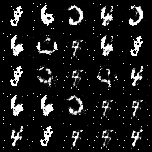

In [32]:
from IPython.display import Image
Image('92000.png')